### Load Data

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
import nibabel as nib
import SimpleITK as sitk
from nipype.interfaces.ants import N4BiasFieldCorrection

import os
import multiprocessing
from subprocess import call
from joblib import Parallel, delayed

In [5]:
data_path = "Task04_Hippocampus/"  # "Task01_BrainTumour/"
folders = sorted(os.listdir(data_path))[2:]
file_names = [path for path in sorted(os.listdir(data_path + folders[0])) if path[0].isalpha()]
#img_path = [data_path + folders[0] + '/' + path for path in sorted(os.listdir(data_path + folders[0])) if path[0].isalpha()]
#roi_path = [data_path + folders[-1] + '/' + path for path in sorted(os.listdir(data_path + folders[-1])) if path[0].isalpha()]
#img_path = os.path.join(data_path, 'imagesTr/BRATS_001.nii.gz')
#roi_path = os.path.join(data_path, 'labelsTr/BRATS_001.nii.gz')
print(len(file_names))

260


In [6]:
[patient for patient in file_names[0:2]]

['hippocampus_001.nii.gz', 'hippocampus_003.nii.gz']

In [7]:
data_path[:-1]

'Task04_Hippocampus'

In [8]:
n4_iterations = [50,50,30,20]
spacing = '1,1,1'
interp_type = 'nearestNeighbor'
work_dir = '/Users/aprilyan/Documents/capstone/MSD/'
interp_type = 'nearestNeighbor'
slicer_dir = '/Users/aprilyan/Applications/Slicer-4.11.20210226-macosx-amd64/Slicer'

In [9]:
def generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename):
    """
    subfolder = '/imagesTr', '/labelsTr'
    """
    input_filepath = work_dir + data_path[:-1] + subfolder +'/' + input_filename
    output_filepath = work_dir + data_path[:-1] + folder_tag + subfolder + '/' + input_filename
    
    return input_filepath, output_filepath

In [10]:
generate_filepath(work_dir, data_path, subfolder='/imagesTr', input_filename=file_names[10], folder_tag='_normal')

('/Users/aprilyan/Documents/capstone/MSD/Task04_Hippocampus/imagesTr/hippocampus_019.nii.gz',
 '/Users/aprilyan/Documents/capstone/MSD/Task04_Hippocampus_normal/imagesTr/hippocampus_019.nii.gz')

In [11]:
file_test = generate_filepath(work_dir, data_path, subfolder='/imagesTr', input_filename=file_names[0], folder_tag='_normal')

In [12]:
nib_vol = nib.load(work_dir+'Patients_Hippocampus/Train/Hippocampus_001/roi.nii.gz').get_fdata()
np.unique(nib_vol)

array([0., 1., 2.])

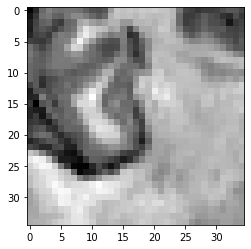

In [42]:
plt.imshow(nib_vol[:,25,:], cmap='gray')

### Preprocessing: 3 steps (resampling, bias correction, normalization)

#### Resampling: voxel spacing = 1,1,1

In [8]:
# this one doesn't work because of slicer 
def resample_vol_slicer(work_dir, data_path, voxel_spacing, slicer_dir, interp_type,
                        subfolder, input_filename, folder_tag=""):
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename)
    module_name = 'ResampleScalarVolume'
    resample_scalar_volume_command = [slicer_dir,'--launch', module_name, '"' + input_filepath + '" "' + output_filepath + '"', 
                                      '-i', interp_type, '-s', voxel_spacing]
    call(' '.join(resample_scalar_volume_command), shell=True)
    return output_filepath

In [9]:
def resampling_vol(work_dir, data_path, voxel_spacing, subfolder, input_filename, folder_tag=""):
    """
    input_filepath: one for each iteration
    voxel_spacing = (1,1,1,1)
    """
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename)
    nib_vol = nib.load(input_filepath)
    affine = nib_vol.get_affine()
    header = nib_vol.get_header()
    vol = nib_vol.get_data()
    header.set_zooms(voxel_spacing)
    nib_vol_resampled = nib.Nifti1Image(vol, affine, header=header)
    nib.save(nib_vol_resampled, output_filepath)
    
    return output_filepath

#### N4 Bias Correction

In [10]:
# def n4_bias_correction(nifti_dir, patient, vols_to_process, n4_iterations, mask_image=None, append_tag=None):
#     #input/output filepaths
#     input_filepaths, output_filenames, output_filepaths = generate_filepaths(nifti_dir, patient, vols_to_process, append_tag)
#     for input_filepath, output_filepath in zip(input_filepaths, output_filepaths):
#         n4 = N4BiasFieldCorrection(output_image = output_filepath)
#         n4.inputs.input_image = input_filepath
#         n4.inputs.n_iterations = n4_iterations
#         if mask_image != None:
#             n4.inputs.mask_image = os.path.join(nifti_dir + patient, mask_image)
#         n4.run()
#     #return created file names
#     return output_filenames

In [20]:
def n4_bias_correction(n4_iterations, work_dir, data_path, input_filename, subfolder, folder_tag='_process', image_dim=4):
    """
    folder_tag='_process/imagesTr'
    """
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename)
    n4 = N4BiasFieldCorrection(output_image = output_filepath)
    n4.inputs.dimension = image_dim
    n4.inputs.input_image = input_filepath 
    n4.inputs.n_iterations = n4_iterations 
    n4.run()
    
    return output_filepath

#### Register labels for slicer visualization

In [12]:
def register_labels(new_affine, work_dir, data_path, input_filename, subfolder, folder_tag='_register'):
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename)
    nib_vol = nib.load(input_filepath)
    header = nib_vol.get_header()
    roi = nib_vol.get_data()
    nib_vol_resampled = nib.Nifti1Image(roi, new_affine, header=header)
    nib.save(nib_vol_resampled, output_filepath)

In [13]:
new_affine = [[-1, 0, 0 ,0],[0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
def all_register(patient):
    register_labels(new_affine, work_dir, data_path, 
                    input_filename=patient, subfolder='/labelsTr', folder_tag='_register')
# num_cores = multiprocessing.cpu_count()
# Parallel(n_jobs=num_cores)(delayed(all_register)(patient) for patient in file_names)

#### Intensity Normalization

In [14]:
def vol_normalization(work_dir, data_path, input_filename, subfolder,
                     only_nonzero=False, reference_volume = None, skull_mask_volume=None,
                      normalization_params=np.array([]), folder_tag='_normal'):
    """
    folder_tag='_normal/imagesTr'
    """
    input_filepath, output_filepath = generate_filepath(work_dir, data_path, folder_tag, subfolder, input_filename)
    nib_vol = nib.load(input_filepath)
    affine = nib_vol.get_affine()
    header = nib_vol.get_header()
    vol = nib_vol.get_fdata()

    if len(normalization_params) > 0 and len(normalization_params.shape) == 1:
        normalization_params = np.tile(normalization_params, (len(vols_to_process), 1))
    if reference_volume != None:
        reference_vol = nib.load(os.path.join(nifti_dir + patient, reference_volume)).get_data()
        skull_mask = (reference_vol != 0).astype(np.int)
    if skull_mask_volume != None:
        skull_mask_vol = nib.load(os.path.join(nifti_dir + patient, skull_mask_volume)).get_data()
        skull_mask = (skull_mask_vol != 0).astype(np.int)

    #Normalize only non-zero intensity values (if flag set to true)
    if only_nonzero == True and reference_volume == None and skull_mask_volume == None:
        idx_nz = np.nonzero(vol)
    elif only_nonzero == True and (reference_volume != None or skull_mask_volume != None):
        idx_nz = np.nonzero(skull_mask)
    else:
        idx_nz = np.where(vol)
    
    if len(normalization_params) == 0:
        mean, std = np.mean(vol[idx_nz]), np.std(vol[idx_nz])
    else:
        mean, std = normalization_params[i, :]
    vol_norm = np.copy(vol)
    
    if reference_volume == None:
        vol_norm[idx_nz] = (vol_norm[idx_nz] - mean) / std
    else:
        vol_norm = (vol_norm - mean) / std
    nib_vol_norm = nib.Nifti1Image(vol_norm, affine, header=header)
    nib.save(nib_vol_norm, output_filepath)
    
    return output_filepath

In [15]:
# work_dir = '/Users/aprilyan/Documents/capstone'
# output_filepath = work_dir + '/MSD/Task01_BrainTumour_process/imagesTr' + '/BRATS_001.nii.gz'
# input_filepath = output_filepath

# output_filepath = work_dir + '/MSD/Task01_BrainTumour_normal/imagesTr' + '/BRATS_001.nii.gz'
# print(input_filepath)
# print(output_filepath)

### Run processing over all images

In [24]:
def all_preprocessing(patient):
#     resampled_img = resample_vol_slicer(work_dir, data_path, spacing, slicer_dir, interp_type,
#                         subfolder='/imagesTr', input_filename=patient, folder_tag="")
#     resampled_roi = resample_vol_slicer(work_dir, data_path, spacing, slicer_dir, interp_type,
#                         subfolder='/labelsTr', input_filename=patient, folder_tag="")
#     resampled_img = resample_vol_slicer(work_dir, data_path, voxel_spacing=(1.0, 1.0, 1.0, 1.0), 
#                                    input_filename=patient, subfolder='/imagesTr', folder_tag="")
#     resampled_roi = resampling_vol(work_dir, data_path, voxel_spacing=(1.0, 1.0, 1.0), 
#                                    input_filename=patient, subfolder='/labelsTr', folder_tag="")
    process_img = n4_bias_correction(n4_iterations, work_dir, data_path, 
                                     input_filename=patient, subfolder='/imagesTr', folder_tag='_process',
                                    image_dim=3)
    normalize_img = vol_normalization(work_dir, data_path, 
                                      input_filename=patient, subfolder='/imagesTr',
                                      only_nonzero=False, reference_volume=None, skull_mask_volume=None,
                                      normalization_params=np.array([]), folder_tag='_normal')
    return print('Done')

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(all_preprocessing)(patient) for patient in file_names[8:])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
patient = file_names[0]
resampled_img = resample_vol_slicer(work_dir, data_path, spacing, slicer_dir, interp_type,
                        subfolder='/imagesTr', input_filename=patient, folder_tag="_resample")

In [ ]:
resampled_img